In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

linear2db = lambda x: 10*np.log10(x) 
db2linear = lambda x: np.power(10,x/10)

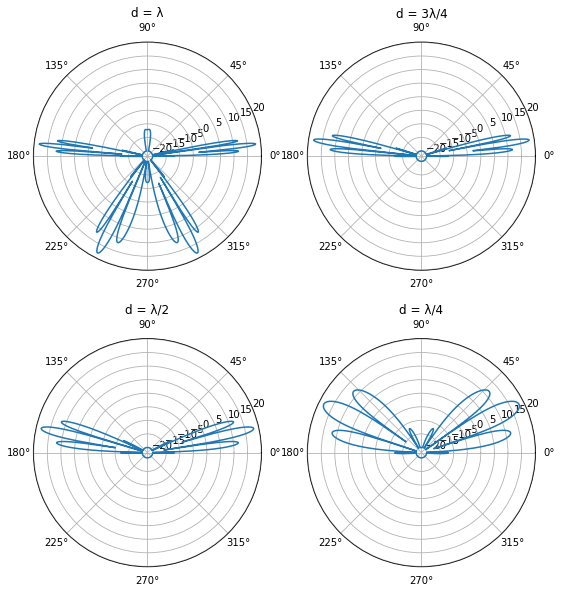

In [6]:
def GetGain(λ, d, N, w, shift = 0):
    
    k = 2 * np.pi / np.abs(λ)
    locations = np.arange(N) * d
    
    samples = 1000
    gain = np.zeros(samples)
    phis = np.linspace(0,2*np.pi,samples)
    
    beta = np.arange(N) * np.pi * shift / 180
    
    for index, phi in enumerate(phis):
        gain[index] = np.sum(w * np.exp(1j * beta) * np.exp(locations * -1j * k * np.sin(phi))) #Compute per phi
    
    gain = linear2db(np.abs(gain) ** 2) # Convert to db and the antenna power 
    
    return np.clip(gain,-20,np.inf)     # Delete highly negative numbers (i.e. x < -20)
    


λ = 1                 # Wave length
d = λ                 # Distance between 2 antennas
N = 16                # Num of antennas in the array
w = np.hamming(N)     # Weights by hamming

shift = 40            # Phase shift in degrees

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9,10) ,subplot_kw={'projection': 'polar'})  

axs[0, 0].set_title("d = λ")
axs[0, 1].set_title("d = 3λ/4")
axs[1, 0].set_title("d = λ/2")
axs[1, 1].set_title("d = λ/4")

axs[0, 0].plot(np.linspace(0,2*np.pi,1000),GetGain(λ,d,N,w,shift))
axs[0, 1].plot(np.linspace(0,2*np.pi,1000),GetGain(λ,d*0.75,N,w ,shift))
axs[1, 0].plot(np.linspace(0,2*np.pi,1000),GetGain(λ,d*0.5,N,w,shift))
axs[1, 1].plot(np.linspace(0,2*np.pi,1000),GetGain(λ,d*0.25,N,w,shift))

plt.show()

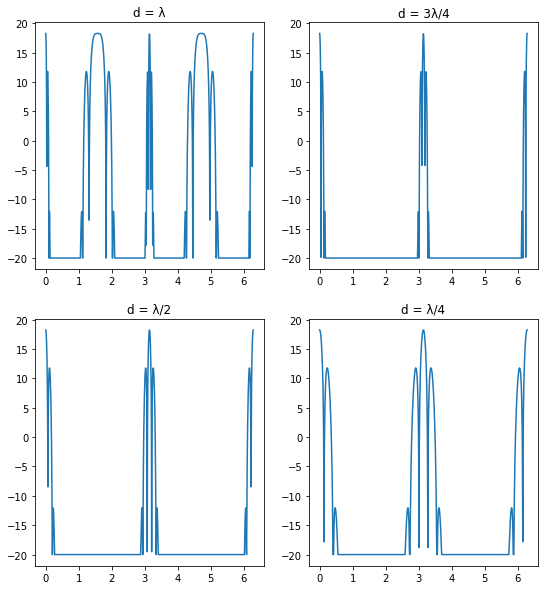

In [8]:
# Plot without shifting just to see the sidelobes

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9,10))

axs[0, 0].set_title("d = λ")
axs[0, 1].set_title("d = 3λ/4")
axs[1, 0].set_title("d = λ/2")
axs[1, 1].set_title("d = λ/4")

axs[0, 0].plot(np.linspace(0,2*np.pi,1000),GetGain(λ,d,N,w))
axs[0, 1].plot(np.linspace(0,2*np.pi,1000),GetGain(λ,d*0.75,N,w))
axs[1, 0].plot(np.linspace(0,2*np.pi,1000),GetGain(λ,d*0.5,N,w))
axs[1, 1].plot(np.linspace(0,2*np.pi,1000),GetGain(λ,d*0.25,N,w))

plt.show()